# **Generate T2_PD H5 files of IXI dataset:**
---

## **Import libraries:**

In [2]:
# !pip install torch-summary
# pip install tqdm
# !pip install monai
# !pip install h5py
# !pip install pandas
# !pip install scikit-image
# !pip install voila

In [1]:
import ants
import SimpleITK as sitk
import sys
import glob
import os
# %matplotlib inline
import matplotlib.pyplot as plt

# sys.path.insert(0,'./basics/')
import basics.slice_view as slice_view

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# torchsummary and torchvision
from torchsummary import summary
from torchvision.utils import save_image

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time

import pathlib
import random

import h5py
# from torch.utils.data import Dataset
import torch
from skimage import feature
# from utils import npComplexToTorch

## **Visualizing:**

In [2]:
link_IXI_t2='/media/Data/MRI/datasets/dataset_creation/IXI/niifiles/t2_nii/'
link_IXI_pd='/media/Data/MRI/datasets/dataset_creation/IXI/niifiles/pd_nii/'
link_IXI_t1='/media/Data/MRI/datasets/dataset_creation/IXI/niifiles/t1_nii/'
out_link='/media/Data/MRI/datasets/translation_imputation/ixi_t2_pd/'

In [3]:
def display(link):
    img=sitk.ReadImage(link)
    img2=sitk.GetArrayFromImage(img)
    slv1 = slice_view.slicer(img2)
    slv1.slicer_view()
    return

In [4]:
display(link_IXI_pd+'IXI016-Guys-0697-PD.nii.gz')

interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

In [ ]:
img=sitk.ReadImage(link_IXI_t2+'IXI016-Guys-0697-T2.nii.gz')
img2=sitk.GetArrayFromImage(img)
print(img2.shape)
type(img2)
plt.imshow(img2[64,:,:],'gray')

In [ ]:
# l

In [ ]:
img = sitk.ReadImage(link_IXI_t1+'IXI002-Guys-0828-T1.nii.gz')
img2= sitk.GetArrayFromImage(img)
print(img2.shape)
type(img2)
plt.imshow(img2[90,:,:],'gray')


## **Data_loader:**

In [ ]:
import os
import glob
import numpy as np
import torch
from tqdm.notebook import tqdm
from monai.data import ITKReader,NibabelReader
from monai.transforms import LoadImage, LoadImaged
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
from monai.data import Dataset
import h5py

class H5CachedDataset(Dataset):
    def __init__(self,niilist,masklist1,
                 transforms_offline, transforms_online=ToTensord(('T2',)),
                 nslices_per_image = 130 ,
                 start_slice = 0,
                 end_slice = 129,                
                 h5cachedir=None):
        #### nslices_per_image ---> total slice in the volume
        #### h5cachedir ---> directory to save one .h5 files for each volume & it would act like a cache directory
        #### if h5cachedir does not exist create one 
#         print(transforms_online)

        if h5cachedir is not None:
            if not os.path.exists(h5cachedir):
                os.mkdir(h5cachedir)
            self.cachedir = h5cachedir
        #### datalist ---> a list [{'image': volume_1_path},......,{'image': volume_n_path}]
        #### masklist ---> a list [{'mask': mask_1_path},......,{'image': mask_n_path}]
#         self.id=id_
        self.datalist = niilist
        self.masklist1 = masklist1
        
        self.xfms = transforms_offline
        self.xfms2 = transforms_online
        #### 3d image loader from monai
        self.loader = LoadImage()
        self.loader.register(NibabelReader())  
        #### start_slice & end_slice---> slices to be truncated in each volume vol[:,:,start_slice:-end_slice]
        self.start_slice = start_slice
        self.end_slice = end_slice
        #### nslices ---> nslices_per_image - end_slice i.e. slice value after end truncation
        #            ---> nslices is kept flexible so that index is obtained by adding front truncation value &
        #            ---> total length of the loder is caluclated considering subtracting front truncation value
        self.nslices = nslices_per_image - self.end_slice
        print(self.nslices) #13
        
    def __len__(self):
        #### total number of slices in all the volumes
        return len(self.datalist)*(self.nslices - self.start_slice)
    
    def clear_cache(self):
        #### function to clear the directory storing h5 files (used for caching the h5 files)
        for fn in os.listdir(self.cachedir):
            os.remove(self.cachedir+'/'+fn)
            
    def __getitem__(self,index):
        #### ditionary to store data slicewise
        data = {}
        #### index can take values from 
                # 0 to (total number of volumes * (len(datalist)*(nslices - start_slice)))  
        #### filenum can take values from 0 to total number of volumes
        #### slicenum can take values from 0 to (len(datalist)*(nslices - start_slice))
        filenum = index // (self.nslices - self.start_slice)
        slicenum = index % (self.nslices - self.start_slice)
        slicenum += self.start_slice
        
        #### Extract the datafile location & mask file location based on filenum
        datalist_filenum = self.datalist[filenum]
        loc_data = datalist_filenum['T2']

        masklist1_filenum = self.masklist1[filenum]
        loc_mask1 = masklist1_filenum['PD']
        print(filenum,slicenum)
        
        ##### if h5 exists for the current volume fill data dictionary with current slice number
        if self.cachedir is not None:
            h5name = self.cachedir+'/%d.h5' % filenum
            ptname = self.cachedir+'/%d.pt' % filenum
#             ptname = self.cachedir+'/%d.pt' % self.id

            if os.path.exists(h5name):
                with h5py.File(h5name,'r') as itm:
                    for key in itm.keys():                       
                        data[key]=torch.from_numpy(itm[key][:,:,:,slicenum])
                data['image_meta_dict']={'affine':np.eye(3)} # FIXME: loses spacing info - can read from pt file

        
        ##### if data dictionary is empty
        if len(data)==0:
            #### Read image & mask data, meta data
            imgdata, meta = self.loader(loc_data)
            mask_data1, mask_meta1 = self.loader(loc_mask1)

            #### store volume wise image & mask data,metadata in a dictionary 
            data_i = {'T2':imgdata,'PD':mask_data1, 'image_meta_dict':meta, 'label_meta_dict1':mask_meta1}
            #### transform the data dictionary
            data3d = self.xfms(data_i)
            #### Create h5 file for the volume by chunking into the slice shape for data & mask 
            #### Create a .pt file for meta data
            if self.cachedir is not None:
                other = {}
                with h5py.File(h5name,'w',libver='latest') as itm:
                    for key in data3d:
                        if key=='T2' or key=='PD':                             
                            img_npy = data3d[key].numpy()
                            shp = img_npy.shape
                            chunk_size = list(shp[:-1])+[1]
                            ds = itm.create_dataset(key,shp,chunks=tuple(chunk_size),dtype=img_npy.dtype)
                            ds[:]=img_npy[:]
                            
                    else:
                        other[key]=data3d[key]
                torch.save(other,ptname)


            #### fill the data dictionary
            data = {
                'T2':data3d['T2'][:,:,:,slicenum],
                'PD':data3d['PD'][:,:,:,slicenum],
                'image_meta_dict':{
                    'affine':np.eye(3)
                }
            }
            
            
#         print(self.__getitem__)
        if len(data)>0:
#             print("**",data.keys())
#             res = self.xfms2(data)
            res = data
            res['T2']=res['T2'].float()
            res['PD']=res['PD'].float()
            res['filenum'] = filenum
            res['slicenum'] = slicenum
            res['idx'] = index
            return res

        else:
            # replace with random
            return self.__getitem__(np.random.randint(len(self.datalist)))


In [ ]:
# pip install nibabel

In [ ]:
from monai.data import ITKReader,NibabelReader
from monai.transforms import LoadImage, LoadImaged
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
from monai.data import Dataset
import h5py
# root='/srv/project/APW/gayathri
link_IXI_t2='/media/Data/MRI/datasets/dataset_creation/IXI/niifiles/t2_nii/'
link_IXI_pd='/media/Data/MRI/datasets/dataset_creation/IXI/niifiles/pd_nii/'

datadir=glob.glob(link_IXI_t2)[0] ###T2
maskdir=glob.glob(link_IXI_pd)[0] ###DCE
vol_file_ext = '.nii.gz'
datalist = [{'T2':x} for x in glob.glob(datadir+'IXI**T2'+vol_file_ext) ]
masklist1= [{'PD':x} for x in glob.glob(maskdir+'IXI**PD'+vol_file_ext) ]

my_dict={}
my_dict2={}
for i in range(393):
    d=datalist[i]['T2'].split('/')[-1].split('-T2')[:]
    my_dict[d[0]] = '-T2'+d[1]
    d2=masklist1[i]['PD'].split('/')[-1].split('-PD')[:]
    my_dict2[d2[0]] = '-PD'+d2[1]
# datalist = [{'T2':x} for x in datadir]l=[]
l=[]
k=[]
for i in range(393):
    l.append({'T2':link_IXI_t2+sorted(my_dict)[i]+my_dict[sorted(my_dict)[i]]})
    k.append({'PD':link_IXI_pd+sorted(my_dict2)[i]+my_dict2[sorted(my_dict2)[i]]})

transforms1 = Compose([AddChanneld(('T2','PD')),Orientationd(('T2','PD'),'RAS'),ToTensord(('T2','PD'))])

### The loader is such that it would create h5 files if they are not created when the loader is called and executed
h5cachedir_ = './IXI-dataset/T2_PD_H5' ###saving path                                                               
h5cacheds = H5CachedDataset(l,k,transforms1,h5cachedir=h5cachedir_)


torch.multiprocessing.set_sharing_strategy('file_system')
_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 1,\
                                           shuffle = False)# ,pin_memory = True)
for i,batch in enumerate(_loader):
    print(batch['T2'].shape)
    print(batch['PD'].shape)
    

In [ ]:
# for i,batch in enumerate(_loader):
#     print(batch['T2'].shape)
#     print(batch['PD'].shape)

In [ ]:
len(k)

## **H5 Files:**

In [8]:
import h5py
filename = "/home/gayathri/torchmri/Codes/IXI-dataset/T2_PD_H5/390.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[1]
    print(list(f.keys())[1])
    print(f[a_group_key].shape)

    # Get the data
#     data = list(f[a_group_key])
    data_T2 = np.asarray(f[a_group_key])

    
# data

Keys: <KeysViewHDF5 ['PD', 'T2']>
T2
(1, 256, 256, 130)


## **Checking whether h5 files are correct:**

In [10]:
# type(data_T2)
data_T2.shape
# d=squeeze(data_T2(1,:,:,:))
d=data_T2.reshape(256, 256, 130)

(256, 256)


interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

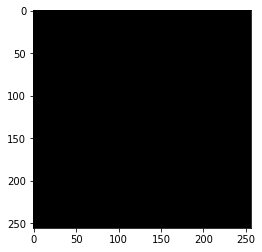

In [11]:
# img2=sitk.GetArrayFromImage(d)
# slv1 = slice_view.slicer(sitk.GetArrayFromImage(sitk.ReadImage(data_T2))
im1=d[:,:,100]
i2=sitk.ReadImage(link_IXI_t2+'IXI652-Guys-1116-T2.nii.gz')
im2=sitk.GetArrayFromImage(i2)
imge2=im2[100,:,:]
print(imge2.shape)
slv1 = slice_view.slicer(np.transpose(d, (1, 0, 2)))
slv1.slicer_view()

plt.imshow(imge2-im1.transpose(),'gray')
# bts=imge2-im1.transpose()


In [6]:
display(link_IXI_t2+'IXI652-Guys-1116-T2.nii.gz')

interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

In [ ]:
# k[390]

---

# **MR Dataset- Flair:IR-->T1-->Flair:**

In [12]:
import h5py
# filename = "/home/gayathri/torchmri/Codes/IXI-dataset/T2_PD_H5/390.h5"
filename = '/media/Data/MRI/datasets/mrbrain_t1/cartesian/train/acc_4x/4.h5'
# filename = '/media/Data/MRI/datasets/mrbrain_ir/cartesian/train/acc_4x/4.h5'
# filename = '/media/Data/MRI/datasets/mrbrain_flair/cartesian/train/acc_4x/4.h5'

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
#     a_group_key = list(f.keys())['img_volus_4x']
    a=f['img_volus_4x']
    b=f['kspace_volus_4x']
    c=f['volfs']
    print(list(f.keys())[2])
    print(f[a_group_key].shape)

    # Get the data
#     data = list(f[a_group_key])
    data_img = np.asarray(a)
    data_k = np.asarray(b)
    data_full = np.asarray(c)

    
# data

Keys: <KeysViewHDF5 ['img_volus_4x', 'kspace_volus_4x', 'mask', 'volfs']>
mask
(240, 240, 48)


In [13]:
data_full.shape

(240, 240, 48)

In [14]:
# # data_img.shape

# import nibabel as nib

# ni_img = nib.Nifti1Image(data_img, affine=np.eye(4))
# nib.save(ni_img, "volume_4ximage.nii")
# ni_img2 = nib.Nifti1Image(data_k, affine=np.eye(4))
# nib.save(ni_img2, "volume_kimage.nii")
# ni_img3 = nib.Nifti1Image(data_full, affine=np.eye(4))
# nib.save(ni_img3, "volume_fullimage.nii")


In [12]:
slv1 = slice_view.slicer(data_t1)
slv1.slicer_view()

interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [15]:
# data_T1
slv1 = slice_view.slicer(data_flr)
slv1.slicer_view()

interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [13]:
# type(data_T1)
slv1 = slice_view.slicer(data_ir)
slv1.slicer_view()

interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
patient_id =list(range(0, 5))
patient_id

import os
root='/media/Data/MRI/datasets/'
filename1 = '/media/Data/MRI/datasets/mrbrain_t1/cartesian/train/acc_4x/'
filename2 = '/media/Data/MRI/datasets/mrbrain_ir/cartesian/train/acc_4x/'
filename3 = '/media/Data/MRI/datasets/mrbrain_flair/cartesian/train/acc_4x/'
if (os.path.isfile(os.path.join(filename1, str(2) + ".h5"))):
    print('yes')
else: print('no')

In [ ]:
root='/media/Data/MRI/datasets/'
filename1 = '/media/Data/MRI/datasets/mrbrain_t1/cartesian/train/acc_4x/'
filename2 = '/media/Data/MRI/datasets/mrbrain_ir/cartesian/train/acc_4x/'
filename3 = '/media/Data/MRI/datasets/mrbrain_flair/cartesian/train/acc_4x/'

class mrDataset(torch.utils.data.Dataset):

    def __init__(self, root, mode="train"):

#         files = sorted(os.listdir(root))
#         patient_id = list(set([i.split()[0] for i in files]))
        patient_id =list(range(0, 5))

        imgs_t1 = []
        imgs_ir = []
        imgs_flr = []

        if mode == "train":
            for i in range(len(patient_id)):
                if (os.path.isfile(os.path.join(filename1, str(i) + ".h5"))):
                    imgs_t1.append(h5py.File(os.path.join(filename1, str(i) + ".h5"), "r"))
                if (os.path.isfile(os.path.join(filename2, str(i) + ".h5"))):
                    imgs_ir.append(h5py.File(os.path.join(filename2, str(i) + ".h5"), "r"))
                if (os.path.isfile(os.path.join(filename3, str(i) + ".h5"))):
                    imgs_flr.append(h5py.File(os.path.join(filename3, str(i) + ".h5"), "r"))
                    

        elif mode == "test":
            for i in range(2):
                if (os.path.isfile(os.path.join(filename1, str(i) + ".h5"))):
                    imgs_t1.append(h5py.File(os.path.join(filename1, str(i) + ".h5"), "r"))
                if (os.path.isfile(os.path.join(filename2, str(i) + ".h5"))):
                    imgs_ir.append(h5py.File(os.path.join(filename2, str(i) + ".h5"), "r"))
                if (os.path.isfile(os.path.join(filename3, str(i) + ".h5"))):
                    imgs_flr.append(h5py.File(os.path.join(filename3, str(i) + ".h5"), "r"))

        self.imgs_t1 = imgs_t1
        self.imgs_ir = imgs_ir
        self.imgs_flr = imgs_flr

    def __getitem__(self, index):
#         t1_path, ADC_path, PD_path, DCE_path = self.imgs[index]
        
        t1=self.imgs_t1[index]
        a = list(t1.keys())[3]
        data_t1 = np.asarray(t1[a])
        
        ir=self.imgs_ir[index]
        b = list(ir.keys())[2]
        data_ir = np.asarray(ir[b])
        
        flr=self.imgs_flr[index]
        c = list(flr.keys())[2]
        data_flr = np.asarray(flr[c])


        return {"T1": data_t1, "IR": data_ir, "FLR":data_flr}
#         return {"data": data,"labels": labels}
#         return{}

    def __len__(self):
        return len(self.imgs_t1)

In [ ]:
cuda = True if torch.cuda.is_available() else False
print(f"Using cuda device: {cuda}")  # check if GPU is used

# Tensor type (put everything on GPU if possible)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
dataloader = torch.utils.data.DataLoader(mrDataset(root,mode='train'),batch_size=1,shuffle=False)


# Parameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create dataloaders
# batch_size = 40
train_loader =torch.utils.data.DataLoader(mrDataset(root,mode='train'),batch_size=1,shuffle=False)

test_loader = torch.utils.data.DataLoader(mrDataset(root,mode='test'),batch_size=1,shuffle=False)

# Number of epochs
num_epoch = 20

# Train the generator
# generator = train_generator(train_loader, test_loader, num_epoch=num_epoch,
#                              lr=lr, beta1=beta1, beta2=beta2)

for i, batch in enumerate(train_loader):

    # Inputs T1-w and T2-w
    real_t1 = batch["T1"].type(Tensor)
    print(real_t1.shape)
    real_ir = batch["IR"].type(Tensor)
    print(real_ir.shape)
    real_flr = batch["FLR"].type(Tensor)
    print(real_flr.shape)
    

In [18]:
root='/media/Data/MRI/datasets/'

class SliceData(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """
    filename1 = '/media/Data/MRI/datasets/mrbrain_t1/cartesian/train/acc_4x/'
    filename2 = '/media/Data/MRI/datasets/mrbrain_ir/cartesian/train/acc_4x/'
    filename3 = '/media/Data/MRI/datasets/mrbrain_flair/cartesian/train/acc_4x/'

    #def __init__(self, root, acc_factor,dataset_type,mask_path): # acc_factor can be passed here and saved as self variable
    def __init__(self, root): # acc_factor can be passed here and saved as self variable
        # List the h5 files in root 
        fn1 = list(pathlib.Path(filename1).iterdir())
        fn2 = list(pathlib.Path(filename2).iterdir())
        fn3 = list(pathlib.Path(filename3).iterdir())
        self.examples_t1 = []
        self.examples_ir = []
        self.examples_flr = []

        for fname in sorted(fn1):
            with h5py.File(fname,'r') as hf:
                fsvol = hf['volfs']
                num_slices = fsvol.shape[2]
                self.examples_t1 += [(fname, slice) for slice in range(num_slices)]
        for fname in sorted(fn2):
            with h5py.File(fname,'r') as hf:
                fsvol = hf['volfs']
                num_slices = fsvol.shape[2]
                self.examples_ir += [(fname, slice) for slice in range(num_slices)]
        for fname in sorted(fn3):
            with h5py.File(fname,'r') as hf:
                fsvol = hf['volfs']
                num_slices = fsvol.shape[2]
                self.examples_flr += [(fname, slice) for slice in range(num_slices)]

    def __len__(self):
        return len(self.examples_t1)

    def __getitem__(self, i):
        # Index the fname and slice using the list created in __init__
        
        fname1, slice = self.examples_t1[i] 
        fname2, slice = self.examples_ir[i]
        fname3, slice = self.examples_flr[i]
        # Print statements 
        #print (fname,slice)
    
        with h5py.File(fname1, 'r') as data:    
            t1 = data['volfs'][:,:,slice].astype(np.float64)
        with h5py.File(fname2, 'r') as data:    
            ir = data['volfs'][:,:,slice].astype(np.float64)
        with h5py.File(fname3, 'r') as data:    
            flr = data['volfs'][:,:,slice].astype(np.float64)
            
            


        return torch.from_numpy(t1), torch.from_numpy(ir), torch.from_numpy(flr)
            

In [19]:
dataloader = torch.utils.data.DataLoader(SliceData(root),batch_size=1,shuffle=False)


NameError: name 'filename1' is not defined

In [3]:
for i,batch in enumerate(dataloader):
    real_t1=batch[0]
    real_ir=batch[1]
    real_flr=batch[2]
    print(real_t1.shape)
    print(real_ir.shape)
    print(real_flr.shape)
    break
real_t1.shape   

NameError: name 'dataloader' is not defined

In [2]:

d=real_t1.reshape(240, 240)

# plt.imshow(d,'gray')
real_t1.size(0)
# bts=imge2-im1.transpose()
# d.shape

NameError: name 'real_t1' is not defined

In [ ]:
d2=real_ir.reshape(240, 240)
plt.imshow(d2,'gray')

In [ ]:
d3=real_flr.reshape(240, 240)
plt.imshow(d3,'gray')